In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# *Step 1: Downloading the GoEmotions Dataset*
- In this project, we aim to build a model that can detect and classify emotions expressed in text. To achieve this, we will use the GoEmotions dataset, which is a rich source of emotional annotations from Reddit comments.

In [2]:
!kaggle datasets download -d mathurinache/goemotions

Dataset URL: https://www.kaggle.com/datasets/mathurinache/goemotions
License(s): CC-BY-NC-SA-4.0
 33%|████████████▍                         | 5.00M/15.3M [00:00<00:00, 30.6MB/s]
100%|██████████████████████████████████████| 15.3M/15.3M [00:00<00:00, 75.4MB/s]


**Purpose:** By downloading the GoEmotions dataset, we are setting the foundation for our analysis and model training. This dataset will enable us to understand and classify various emotional responses, which is crucial for tasks such as sentiment analysis and natural language processing.

# *Step 2: Importing TensorFlow and Keras*
- In this step, we will import the necessary libraries for building our machine learning model. We will use TensorFlow, a powerful deep learning framework, along with Keras, which is a high-level API for building and training neural networks.

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


**Purpose:** Importing these libraries is essential for the subsequent steps where we will preprocess the data, build our neural network model, and train it on the GoEmotions dataset. This foundation will enable us to leverage deep learning techniques for emotion detection.

# *Step 3: Extracting the Dataset*
- After downloading the GoEmotions dataset, the next step is to extract the contents of the ZIP file. We will use Python's built-in zipfile module for this purpose.

In [4]:
from zipfile import ZipFile
with ZipFile('goemotions.zip') as zipref:
  zipref.extractall()

# *Step 4: Loading the Dataset*
- Now that we have extracted the dataset, the next step is to load the data into a Pandas DataFrame for analysis and preprocessing.

In [6]:
dataset = pd.read_csv("GoEmotions.csv")
dataset.head()

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,0,1


# *Step 5: Extracting Texts and Labels*
- In this step, we will extract the text data and corresponding labels from the DataFrame to prepare for model training.
- texts = dataset['text'].values: This line extracts the text data from the 'text' column of the DataFrame and stores it in a NumPy array. The values attribute converts the DataFrame column into an array format suitable for further processing.

- labels = dataset[dataset.columns[9:]].values: This line extracts the labels corresponding to various emotions, which are located in columns 9 and onward of the DataFrame. The resulting array contains binary indicators for each emotional label.

- dataset.shape: This method returns the dimensions of the DataFrame, giving us insight into the number of rows (samples) and columns (features) in the dataset.

In [7]:
texts = dataset['text'].values
labels = dataset[dataset.columns[9:]].values

In [8]:
dataset.shape

(211225, 37)

# *Step 6: Analyzing Emotion Distribution*
- In this step, we will analyze the distribution of emotions in the dataset by summing the occurrences of each emotion across all text samples. This will help us understand the class distribution and identify any imbalances.

neutral           55298
approval          17620
admiration        17131
annoyance         13618
gratitude         11625
disapproval       11424
curiosity          9692
amusement          9245
realization        8785
optimism           8715
disappointment     8469
love               8191
anger              8084
joy                7983
confusion          7359
sadness            6758
caring             5999
excitement         5629
surprise           5514
disgust            5301
desire             3817
fear               3197
remorse            2525
embarrassment      2476
nervousness        1810
pride              1302
relief             1289
grief               673
dtype: int64


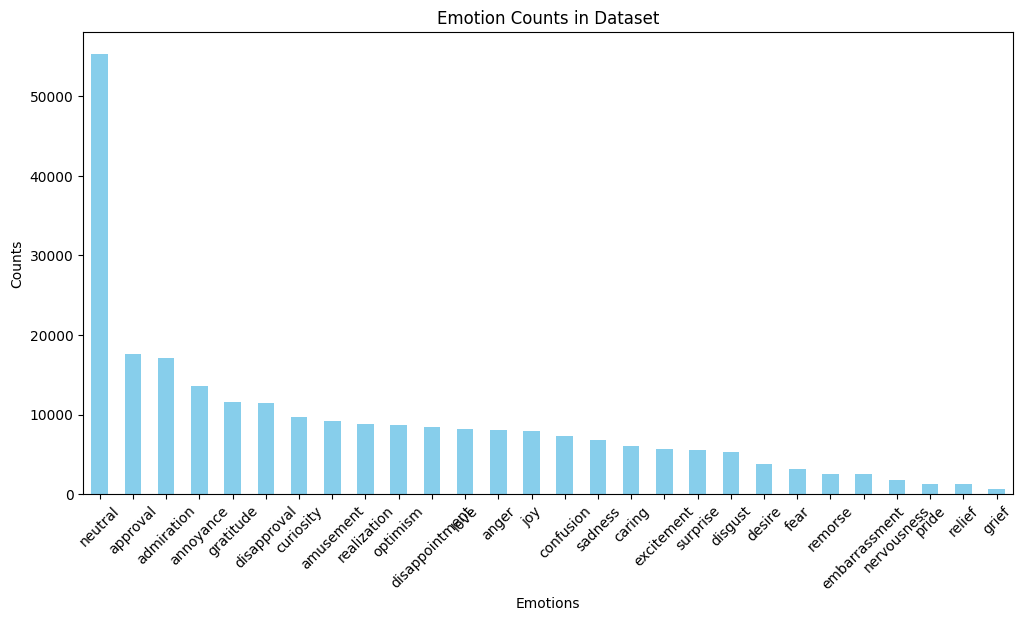

In [9]:
# Assuming 'df' is your DataFrame where each column represents an emotion
# and 1 indicates the presence of an emotion in that text, 0 indicates absence.

# Sum the values across all rows for each emotion column
emotion_counts = dataset[['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
       'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
       'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
       'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
       'relief', 'remorse', 'sadness', 'surprise', 'neutral']].sum().sort_values(ascending=False)  # Assuming the last column is not an emotion

# Print the counts for each emotion
print(emotion_counts)

# Plot the counts to visualize class distribution
plt.figure(figsize=(12, 6))
emotion_counts.plot(kind='bar', color='skyblue')
plt.title('Emotion Counts in Dataset')
plt.xlabel('Emotions')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.show()

**Purpose:** Analyzing and visualizing the emotion distribution is essential for understanding the dataset's characteristics. This information will guide our approach to handling class imbalances in later steps, ensuring that our model is trained effectively on the available data.

# *Step 7: Data Preprocessing*
- In this step, we will preprocess the text data and corresponding labels to prepare them for training the model. This includes tokenizing the text and padding sequences to ensure uniform input lengths.
- Tokenization: The Tokenizer class converts the text into sequences of integers, where each integer represents a unique word in the dataset. The oov_token='<OOV>' parameter handles out-of-vocabulary words.

- Padding: The pad_sequences function ensures that all input sequences have the same length (defined by max_len). This is crucial for training neural networks, which require fixed-size inputs.

- Data Splitting: We use train_test_split from Scikit-learn to split the dataset into training, validation, and test sets. The training set is used to train the model, the validation set is used to tune hyperparameters, and the test set is used to evaluate model performance.

In [11]:
def preprocess_data(texts, labels, tokenizer=None, max_len=128):
    if tokenizer is None:
        tokenizer = Tokenizer(oov_token='<OOV>')
        tokenizer.fit_on_texts(texts)
    
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
    
    return padded_sequences, labels, tokenizer

max_len = 128
(X_padded, y_labels, tokenizer) = preprocess_data(texts, labels, max_len=max_len)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_padded, y_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

**Purpose:** Preprocessing the data is a critical step that prepares it for training the model. Properly tokenized and padded sequences ensure that the neural network can effectively learn from the text data while maintaining a consistent input size across all samples.

# *Step 8: Building the Transformer Model*
In this step, we define the architecture of our Transformer model, which will be employed for classifying emotions based on the input text data. We begin by implementing the essential components of the Transformer architecture, starting with the Positional Encoding layer.

## 1. Positional Encoding
The PositionalEncoding class is designed to add positional information to the input embeddings. This is crucial because the Transformer architecture does not inherently capture the order of words.

In [12]:
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()

    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_rads(self, pos, i, d_model):
    angle_rads = 1 / tf.math.pow(10_000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return pos * angle_rads

  def positional_encoding(self, position, d_model):

    pos = tf.range(position, dtype = tf.float32)[:, tf.newaxis]
    i = tf.range(d_model, dtype = tf.float32)[tf.newaxis, :]

    angle_rads = self.get_rads(pos, i, d_model)

    sin_cos_encoding = tf.where(
        tf.math.mod(tf.range(d_model), 2) == 0,
        tf.math.sin(angle_rads),
        tf.math.cos(angle_rads)
    )

    pos_encoding = sin_cos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, x):
    return x + self.pos_encoding[:, :tf.shape(x)[1], :]

Next, we define the Multi-Head Attention layer, which is a core component of the Transformer architecture. This layer enables the model to focus on different parts of the input sequence simultaneously.

## 2. Multi-Head Attention
The MultiHeadAttention class implements the multi-head attention mechanism, allowing the model to attend to different positions in the input sequence for each head.

In [13]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()

    self.d_model = d_model
    self.num_heads = num_heads

    assert d_model % num_heads == 0

    self.depth = d_model // num_heads

    self.Wq = tf.keras.layers.Dense(d_model)
    self.Wk = tf.keras.layers.Dense(d_model)
    self.Wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm = [0, 2, 1, 3])

  def call(self, q, k, v, mask = None):
    batch_size = tf.shape(q)[0]

    q = self.Wq(q)
    k = self.Wk(k)
    v = self.Wv(v)

    q = self.split_heads(q, batch_size)
    k = self.split_heads(k, batch_size)
    v = self.split_heads(v, batch_size)

    matmul_qk = tf.matmul(q, k, transpose_b = True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)

    scaled_attn_logits = matmul_qk / tf.math.sqrt(dk)

#     if mask is not None:
#       scaled_attn_logits += mask * -1e9

    attn_weights = tf.nn.softmax(scaled_attn_logits, axis = -1)
    output = tf.matmul(attn_weights, v)

    output = tf.transpose(output, perm = [0, 2, 1, 3])
    output = tf.reshape(output, (batch_size, -1, self.d_model))

    output = self.dense(output)

    return output, attn_weights

Next, we define the Transformer Encoder Layer, which incorporates both the multi-head attention mechanism and a feed-forward neural network.

## 3. Transformer Encoder Layer
The TransformerEncoderLayer class represents a single layer of the Transformer encoder, consisting of multi-head attention followed by a feed-forward network.

In [14]:
class TransformerEncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate = 0.1):
    super(TransformerEncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation = 'relu'),
        tf.keras.layers.Dense(d_model)
    ])

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

    self.layerNorm1 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
    self.layerNorm2 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)

  def call(self, x, training = False):
    attn_output, _  = self.mha(x, x, x)
    attn_output = self.dropout1(attn_output, training = training)
    out1 = self.layerNorm1(x + attn_output)

    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training = training)
    out2 = self.layerNorm2(out1 + ffn_output)

    return out2

Now we define the Transformer Encoder, which stacks multiple encoder layers to process input sequences.

## 4. Transformer Encoder
The TransformerEncoder class is responsible for embedding the input, applying positional encoding, and passing the data through multiple encoder layers.

In [15]:
class TransformerEncoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_positional_encoding, rate = 0.1):
    super(TransformerEncoder, self).__init__()

    self.num_heads = num_heads
    self.d_model = d_model

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = PositionalEncoding(maximum_positional_encoding, d_model)

    self.enc_layers = [TransformerEncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training = False):
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))

    x = self.pos_encoding(x)
    x = self.dropout(x, training = training)

    for layer in self.enc_layers:
      x = layer(x, training = training)

    return x

# *Step 9: Creating the Transformer Classification Model*
- In this step, we define the Transformer model specifically for classification tasks.
- The create_transformer_classification_model function builds the entire architecture of the Transformer model, preparing it for training on the emotion classification task.

In [28]:
def create_transformer_classification_model(num_layers, d_model, num_heads, dff, input_vocab_size,
                                            maximum_positional_encoding, num_classes, rate = 0.1):
  inputs = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='inputs')

  transformer_encoder = TransformerEncoder(num_layers, d_model, num_heads, dff, input_vocab_size, maximum_positional_encoding, rate)

  encoder_output = transformer_encoder(inputs, training=True)

  pooled_output = tf.keras.layers.GlobalAveragePooling1D()(encoder_output)
  outputs = tf.keras.layers.Dense(num_classes, activation = 'sigmoid')(pooled_output)

  model = tf.keras.models.Model(inputs = inputs, outputs = outputs)
  model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])
  return model

# *Step 10: Model Configuration and Initialization*
In this step, we specify the hyperparameters for our Transformer model and create an instance of the model.

In [33]:
num_layers = 3
d_model = 256
num_heads = 8
dff = 512
input_vocab_size = len(tokenizer.word_index)+1
maximum_positional_encoding = 1000
num_classes = 28

model = create_transformer_classification_model(num_layers, d_model, num_heads, 
                                dff, input_vocab_size, maximum_positional_encoding, 
                                                num_classes)

# *Step 11: Model Summary*
To gain insight into the architecture of our Transformer model, we call the summary() method:

In [34]:
model.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_3           │ (None, None, 256)      │    10,050,816 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 28)             │         7,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,058,012 (38.37 MB)

 Trainable params: 10,058,012 (38.37 MB)

 Non-trainable params: 0 (0.00 B)

# *Step 12: Early Stopping Definition*
To prevent overfitting and to save computational resources, we define an early stopping mechanism:

In [35]:

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,          # Number of epochs to wait for improvement
    verbose=1,           # Verbosity mode
    restore_best_weights=True  # Restore the best weights when stopped
)


# *Step 13: Model Training*

- In this step, I initiate the training process for my machine learning model using the fit method. This method is crucial as it allows the model to learn from the training data while validating its performance on a separate validation set. Below is the code I use for this step:

In [36]:
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val), batch_size=32, callbacks = [early_stopping])

Epoch 1/15
4621/4621 ━━━━━━━━━━━━━━━━━━━━ 134s 24ms/step - accuracy: 0.3128 - auc_3: 0.7713 - loss: 0.1500 - precision_3: 0.5661 - recall_3: 0.0445 - val_accuracy: 0.3596 - val_auc_3: 0.8260 - val_loss: 0.1374 - val_precision_3: 0.7563 - val_recall_3: 0.0478
Epoch 2/15
4621/4621 ━━━━━━━━━━━━━━━━━━━━ 95s 21ms/step - accuracy: 0.3548 - auc_3: 0.8281 - loss: 0.1371 - precision_3: 0.6595 - recall_3: 0.0754 - val_accuracy: 0.3599 - val_auc_3: 0.8372 - val_loss: 0.1351 - val_precision_3: 0.6603 - val_recall_3: 0.0914
Epoch 3/15
4621/4621 ━━━━━━━━━━━━━━━━━━━━ 95s 21ms/step - accuracy: 0.3588 - auc_3: 0.8365 - loss: 0.1350 - precision_3: 0.6508 - recall_3: 0.0869 - val_accuracy: 0.3507 - val_auc_3: 0.8331 - val_loss: 0.1367 - val_precision_3: 0.6951 - val_recall_3: 0.0688
Epoch 4/15
4621/4621 ━━━━━━━━━━━━━━━━━━━━ 92s 20ms/step - accuracy: 0.3540 - auc_3: 0.8336 - loss: 0.1360 - precision_3: 0.6637 - recall_3: 0.0783 - val_accuracy: 0.3620 - val_auc_3: 0.8354 - val_loss: 0.1356 - val_precision_

# *Step 14: Making Predictions*

- In this step, I define functions to preprocess input text, make predictions with the trained model, and convert those predictions into human-readable emotion labels. Here’s the code I’ve implemented:

In [38]:
import numpy as np

def predict(texts, tokenizer, model, max_len=128):
    # Preprocess the input text
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
    
    # Make predictions
    predictions = model.predict(padded_sequences)
    
    return predictions

def convert_predictions_to_emotions(predictions, emotion_labels, threshold=0.15):
    # Convert predictions to emotions based on the threshold
    emotions = []
    for pred in predictions:
        detected_emotions = [label for i, label in enumerate(emotion_labels) if pred[i] > threshold]
        emotions.append(detected_emotions)
    return emotions

# Define the emotion labels based on your dataset
emotion_labels = dataset.columns[9:]

# Example texts for prediction
texts_to_predict = ["I really admire the way you handled that situation.",  # admiration
    "That joke was hilarious, I can’t stop laughing!",  # amusement
    "I can't believe you did that, I’m so angry!",  # anger
    "This constant noise is getting really annoying.",  # annoyance
    "I fully approve of your decision to take that course.",  # approval
    "I care about your well-being and want to help.",  # caring
    "I'm confused, could you explain that again?",  # confusion
    "I'm curious ny to know more about your project.",  # curiosity
    "I desire nothing more than to succeed in this endeavor.",  # desire
    "I'm disappointed in how things turned out.",  # disappointment
    "I completely disapprove of your actions.",  # disapproval
    "The smell in here is disgusting.",  # disgust
    "I felt so embarrassed when I fell in front of everyone.",  # embarrassment
    "I'm so excited about the concert next week!",  # excitement
    "I'm scared of what's going to happen next.",  # fear
    "I'm grateful for all the support you've given me.",  # gratitude
    "I am deeply grieving the loss of my friend.",  # grief
    "I'm filled with joy every time I see you.",  # joy
    "I love spending time with you.",  # love
    "I'm nervous about the job interview tomorrow.",  # nervousness
    "I feel optimistic about the future.",  # optimism
    "I take pride in my work.",  # pride
    "I've just realized what went wrong with the code.",  # realization
    "I'm relieved that the test results came back negative.",  # relief
    "I feel remorse for the mistakes I’ve made.",  # remorse
    "I feel really sad about how things turned out.",  # sadness
    "I was surprised by how quickly everything happened.",  # surprise
    "I feel neutral about the situation; it doesn't really affect me.",  # neutral
]

# Make predictions
predictions = predict(texts_to_predict, tokenizer, model)

# Convert predictions to emotions
emotions = convert_predictions_to_emotions(predictions, emotion_labels)

# Display predictions
for text, emotion_list in zip(texts_to_predict, emotions):
    print(f"Text: {text}")
    print(f"Detected Emotions: {emotion_list}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Text: I really admire the way you handled that situation.
Detected Emotions: ['neutral']
Text: That joke was hilarious, I can’t stop laughing!
Detected Emotions: ['amusement']
Text: I can't believe you did that, I’m so angry!
Detected Emotions: ['anger', 'annoyance', 'neutral']
Text: This constant noise is getting really annoying.
Detected Emotions: ['neutral']
Text: I fully approve of your decision to take that course.
Detected Emotions: ['neutral']
Text: I care about your well-being and want to help.
Detected Emotions: ['neutral']
Text: I'm confused, could you explain that again?
Detected Emotions: ['neutral']
Text: I'm curious to know more about your project.
Detected Emotions: ['confusion', 'curiosity', 'neutral']
Text: I desire nothing more than to succeed in this endeavor.
Detected Emotions: ['neutral']
Text: I'm disappointed in how things turned out.
Detected Emotions: ['sadness', 'neutral']
Text: I completely disapprove of your actions.
Det

Explanation of Functions:

1. predict(texts, tokenizer, model, max_len=128):

This function takes in a list of texts, the tokenizer, and the trained model.

It preprocesses the input text by converting the texts to sequences and padding them to ensure they are all of equal length.

The model then makes predictions based on the padded sequences and returns the predictions.



2. convert_predictions_to_emotions(predictions, emotion_labels, threshold=0.15):

This function converts the model's predictions into a list of detected emotions.

It iterates through each prediction and checks if the predicted probability exceeds the specified threshold (0.15). If it does, the corresponding emotion label is added to the detected emotions list.




Emotion Labels

The emotion labels are defined based on the dataset's columns starting from the 9th column, which corresponds to the different emotions I am classifying.

In [53]:
emotion_labels

Index(['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
       'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
       'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
       'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
       'relief', 'remorse', 'sadness', 'surprise', 'neutral'],
      dtype='object')

In [90]:
# Saving the model
model.save('path_to_save_model/my_model.h5')
